# Training Swin Transformer on *Dogs vs Cats Data* 
A hierarchical Transformer whose representation is computed with shifted windows. The shifted windowing scheme brings greater efficiency by limiting self-attention computation to non-overlapping local windows while also allowing for cross-window connection. This hierarchical architecture has the flexibility to model at various scales and has linear computational complexity with respect to image size. These qualities of Swin Transformer make it compatible with a broad range of vision tasks, including image classification and dense prediction tasks such as object detection and semantic segmentation, demonstrating the potential of Transformer-based models as vision backbones.

    
* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
    
* Swim Implementation is from https://github.com/berniwal/swin-transformer-pytorch.git

![](./Sources/2.png)
![](./Sources/swin_transformer.png)

In [1]:
!nvidia-smi

Sat Sep  4 14:27:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install library

In [2]:
!pip install einops==0.3.0

## Import Libraries

In [3]:
from __future__ import print_function

import glob
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

# Setting Parameters

In [4]:
# Training settings
batch_size = 16
EPOCHS = 20
lr = 0.01

## Read and Load Data

In [5]:
os.makedirs('data', exist_ok=True)

In [6]:
train_dir = 'data/train'
test_dir = 'data/test'

In [7]:
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('../input/dogs-vs-cats-redux-kernels-edition/test.zip') as test_zip:
    test_zip.extractall('data')

In [8]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

## Reduce size of data to develop

In [9]:
# import random
# train_list=random.sample(train_list, 2000)
# test_list=random.sample(test_list, 1000)

In [10]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [11]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
len(labels)

25000

## Random Plots

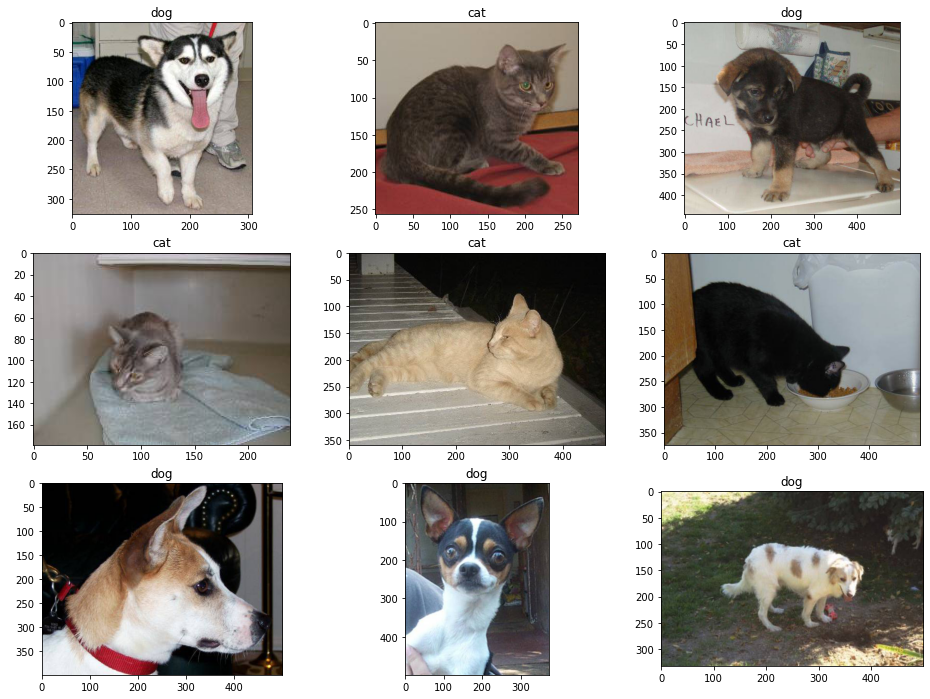

In [12]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Split tarin data 

In [13]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels)

In [14]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Image Augumentation

In [15]:
im_size=224
train_transforms = transforms.Compose(
    [
        transforms.Resize((im_size, im_size)),
        transforms.RandomResizedCrop(im_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((im_size, im_size)),
        transforms.RandomResizedCrop(im_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((im_size, im_size)),
        transforms.RandomResizedCrop(im_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


## Datasets and DataLoaders

In [16]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.classes = ['dog','cat']
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [17]:
train_ds= CatsDogsDataset(train_list, transform=train_transforms)
valid_ds = CatsDogsDataset(valid_list, transform=test_transforms)
test_ds = CatsDogsDataset(test_list, transform=test_transforms)

In [18]:
train_loader = DataLoader(dataset = train_ds, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_ds, batch_size=batch_size, shuffle=True)

In [19]:
print(len(train_ds), len(train_loader))

20000 1250


In [20]:
print(len(valid_ds), len(valid_loader))

5000 313


In [21]:
batch=next(iter(train_loader))
batch[0].shape,batch[1].shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

# Creating Swim Components

In [22]:
import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat

In [23]:
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))

In [24]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [25]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [26]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

In [27]:
def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask

In [28]:
def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances

In [29]:
class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out

In [30]:
class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x

In [31]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()
        self.downscaling_factor = downscaling_factor
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        b, c, h, w = x.shape
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor
        x = self.patch_merge(x).view(b, -1, new_h, new_w).permute(0, 2, 3, 1)
        x = self.linear(x)
        return x

In [32]:
class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)



# SwinTransformer

In [33]:
class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Linear(hidden_dim * 8, num_classes)
        )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = x.mean(dim=[2, 3])

        return self.mlp_head(x)

In [34]:
def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_s(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_b(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


def swin_l(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)


In [35]:
model = SwinTransformer(
    hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=3,
    num_classes=2,  ####
    head_dim=32,
    window_size=7,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
).to(device)


In [36]:
# model = swin_l(
#     channels=3,
#     num_classes=2,  ####
#     head_dim=32,
#     window_size=7,
#     downscaling_factors=(4, 2, 2, 2),
#     relative_pos_embedding=True
# ).to(device)

In [37]:
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

In [6]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch, (inputs, targets) in enumerate(train_loader):
          inputs, targets = inputs.to(device), targets.to(device)

          outputs = model(inputs)
        
          loss = loss_func(outputs, targets)   
          optimizer.zero_grad()           
          loss.backward()                 
          optimizer.step()
      
          acc = (outputs.argmax(dim=1) == targets).float().mean()
          epoch_accuracy += acc / len(train_loader)
          epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for batch, (inputs, targets) in enumerate(valid_loader):
              inputs, targets = inputs.to(device), targets.to(device)


              val_output = model(inputs)
              val_loss = loss_func(val_output, targets)   
          
              acc = (val_output.argmax(dim=1) == targets).float().mean()
              epoch_val_accuracy += acc / len(valid_loader)
              epoch_val_loss += val_loss / len(valid_loader)
                       
    print(  f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")


Epoch : 1 - loss : 0.7423 - acc: 0.4982 - val_loss : 0.6931 - val_acc: 0.5002
Epoch : 2 - loss : 0.6974 - acc: 0.5011 - val_loss : 0.6932 - val_acc: 0.4998
Epoch : 3 - loss : 0.6968 - acc: 0.5010 - val_loss : 0.6970 - val_acc: 0.5000
Epoch : 4 - loss : 0.6982 - acc: 0.5034 - val_loss : 0.6935 - val_acc: 0.5000
Epoch : 5 - loss : 0.6998 - acc: 0.4995 - val_loss : 0.6950 - val_acc: 0.5002


## Evaluate on a Test Image from validation set

Finally, let's evaluate the model on a test image:

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

def lableing(s):
    if s==1:
        label = 'dog'
    else:
        label = 'cat'
    return label

EVAL_BATCH = 1
eval_loader  = DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
with torch.no_grad():
    
  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)
 
  # Generate prediction
  prediction = model(inputs, target)
    
  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  print(int(predicted_class))
  value_predicted = lableing(int(predicted_class))
  value_target = lableing(target)
        
  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()